## Toxic comment multi-class classification using fine-tuned BERT model

#### 1. Dataset

Jigsaw toxic comments data with multi-class labels

https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge




#### 2. Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

# Deep Learning Framework
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import AdamW

# Hugging Face Transformers
!pip install transformers
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, hamming_loss, accuracy_score

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED) # if using CUDA

# Setup device use gpu cuda if avaible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")#

# Configuration (Adjust these as needed)
MODEL_NAME = 'bert-base-uncased'
MAX_LENGTH = 128 # Max sequence length BERT can handle (adjust based on EDA)
BATCH_SIZE = 16 # Adjust based on GPU memory
EPOCHS = 3 # Number of training epochs (BERT fine-tuning usually requires few epochs)
LEARNING_RATE = 2e-5 # Common learning rate for BERT fine-tuning

Using device: cuda


#### 3. Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/My Drive/datasets/jigsaw_multilabel.csv')

Mounted at /content/drive


In [ ]:
print(data.head())

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


#### 4. Exploratory Data Analysis (EDA)

Label Distribution:
               count  percentage
toxic          15294    9.584448
severe_toxic    1595    0.999555
obscene         8449    5.294822
threat           478    0.299553
insult          7877    4.936361
identity_hate   1405    0.880486


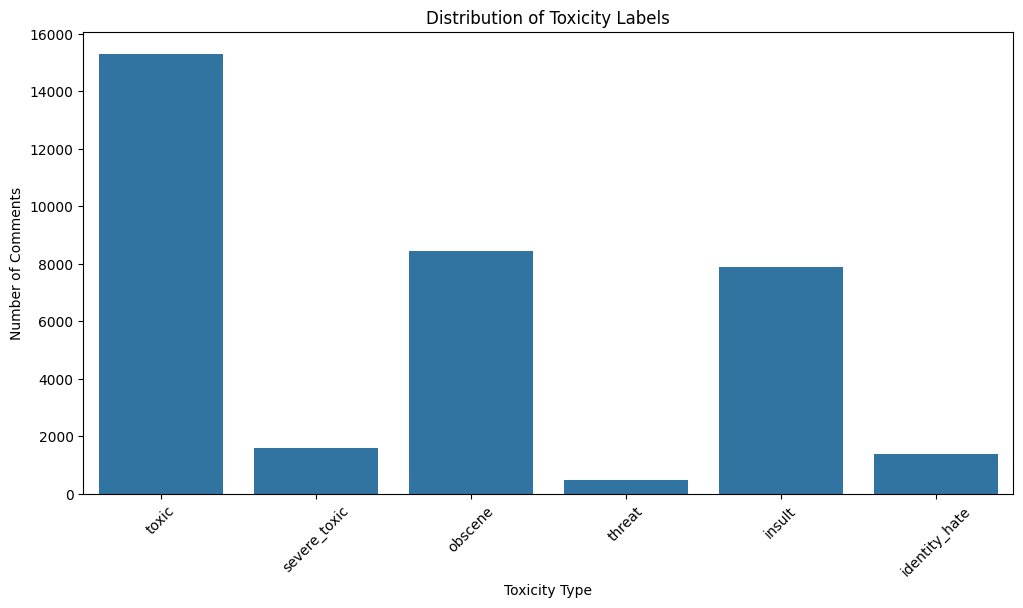


Number of comments with NO toxicity labels: 143346 (89.83%)


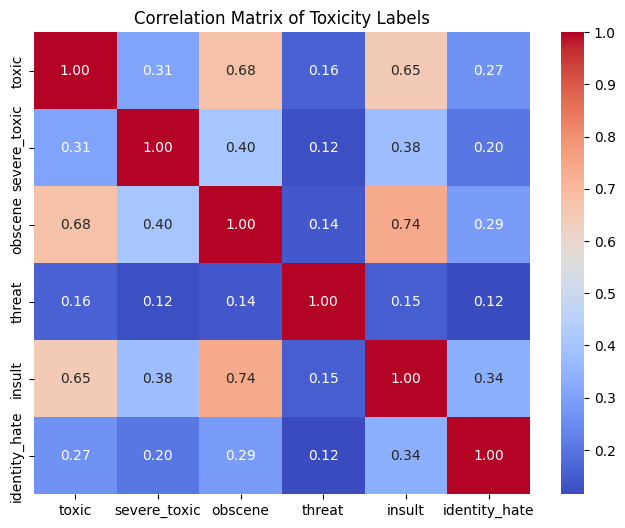

In [ ]:
# Define target labels
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
# Calculate label counts and percentages
label_counts = data[label_cols].sum()
label_percentages = (label_counts / len(data)) * 100

# Create a DataFrame for plotting
label_stats_df = pd.DataFrame({'count': label_counts, 'percentage': label_percentages})
print("Label Distribution:")
print(label_stats_df)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=label_stats_df.index, y=label_stats_df['count'])
plt.title('Distribution of Toxicity Labels')
plt.ylabel('Number of Comments')
plt.xlabel('Toxicity Type')
plt.xticks(rotation=45)
plt.show()

# Check for comments with no labels (clean comments)
no_label_count = len(data[data[label_cols].sum(axis=1) == 0])
print(f"\nNumber of comments with NO toxicity labels: {no_label_count} ({no_label_count / len(data) * 100:.2f}%)")

# Multi-label Correlation
plt.figure(figsize=(8, 6))
sns.heatmap(data[label_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Toxicity Labels')
plt.show()
# Observation: High correlation between 'toxic' and 'obscene'/'insult'. 'Severe toxic' implies 'toxic'.

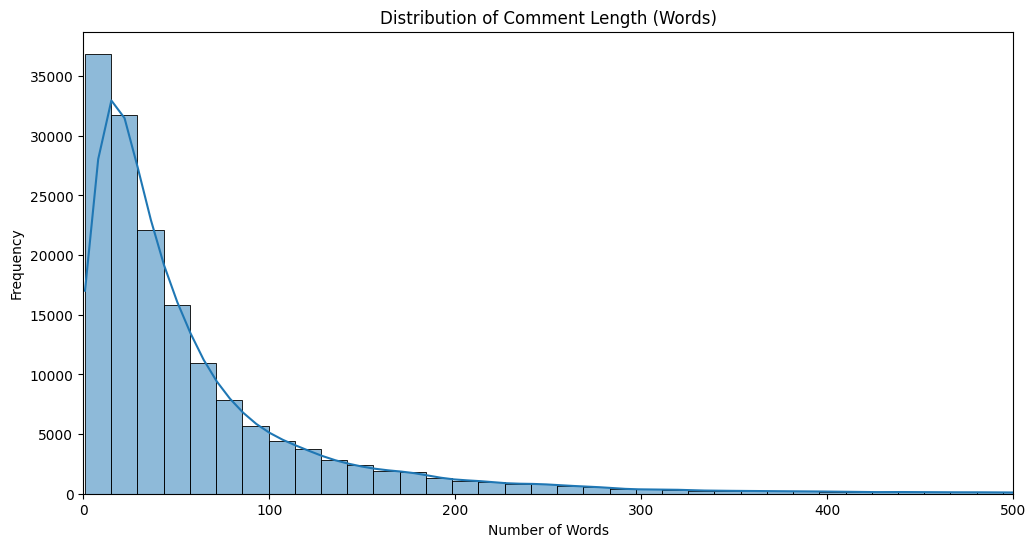


Comment Length Statistics (Words):
count    159571.000000
mean         67.273527
std          99.230702
min           1.000000
25%          17.000000
50%          36.000000
75%          75.000000
max        1411.000000
Name: comment_length, dtype: float64


In [ ]:
data['comment_length'] = data['comment_text'].apply(lambda x: len(x.split()))


plt.figure(figsize=(12, 6))
sns.histplot(data['comment_length'], bins=100, kde=True)
plt.title('Distribution of Comment Length (Words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
# Limit x-axis for better visualization if needed
plt.xlim(0, 500)
plt.show()

print("\nComment Length Statistics (Words):")
print(data['comment_length'].describe())
# Observation: Most comments are well below 512 tokens, but some are longer. MAX_LENGTH=128 or 256 might be reasonable start.

#### 5. Data Preprocessing and Tokenization
Text preprocessing for BERT:
BERT is often pre-trained on raw text, including punctuation and casing. Aggressive cleaning can sometimes hurt performance. Basic cleaning like removing URLs or excessive whitespace might still be beneficial.

##### 5.1 Text Cleaning

In [ ]:
def clean_text(text):
    text = str(text)
    # Remove URLs (optional, BERT might handle some context)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Basic handling of common issues if needed
    text = text.lower() # BERT uncased models handle this
    return text

# Apply cleaning (demonstrative - may skip depending on BERT variant)
# data['comment_text_cleaned'] = data['comment_text'].apply(clean_text)
# Use original text for now as BERT benefits from closer-to-raw text
data['comment_text_cleaned'] = data['comment_text']


##### 5.2 Tokenization with BERT Tokenizer

In [ ]:
# tokenization
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Example tokenization
sample_text = "This is a sample comment for tokenization."
tokens = tokenizer.encode_plus(
    sample_text,
    max_length=32,
    padding='max_length', # Pad to max_length
    truncation=True,      # Truncate longer sequences
    return_tensors='pt'   # Return PyTorch tensors
)

print("\nSample Tokenization:")
print(f"Text: {sample_text}")
print(f"Tokens: {tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])}")
print(f"Input IDs: {tokens['input_ids']}")
print(f"Attention Mask: {tokens['attention_mask']}") # 1 for real tokens, 0 for padding

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]


Sample Tokenization:
Text: This is a sample comment for tokenization.
Tokens: ['[CLS]', 'this', 'is', 'a', 'sample', 'comment', 'for', 'token', '##ization', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
Input IDs: tensor([[  101,  2023,  2003,  1037,  7099,  7615,  2005, 19204,  3989,  1012,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])
Attention Mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])


##### 5.3 Creating Pytorch Datasets and DataLoaders

In [ ]:
#Encapsulate the data and tokenization logic into a PyTorch Dataset class for efficient batch loading.
class ToxicCommentDataset(Dataset):
    def __init__(self, comments, labels, tokenizer, max_len):
        self.comments = comments
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])
        target = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True, # Add '[CLS]' and '[SEP]'
            max_length=self.max_len,
            return_token_type_ids=False, # Not needed for basic BERT classification
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt', # Return PyTorch tensors
        )

        return {
            'comment_text': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(target, dtype=torch.float) # Use float for BCEWithLogitsLoss
        }

# Prepare data for Dataset class
X = data['comment_text_cleaned'].values
y = data[label_cols].values

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.1, # Use 10% for validation
    random_state=SEED,
    # Stratification is complex for multi-label, can skip or use iterative stratification if needed
)

print(f"\nTrain size: {len(X_train)}, Validation size: {len(X_val)}")

# Create Datasets
train_dataset = ToxicCommentDataset(X_train, y_train, tokenizer, MAX_LENGTH)
val_dataset = ToxicCommentDataset(X_val, y_val, tokenizer, MAX_LENGTH)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) # num_workers depends on your system
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Example batch check
data = next(iter(train_dataloader))
print("\nSample batch shapes:")
print("Input IDs:", data['input_ids'].shape)
print("Attention Mask:", data['attention_mask'].shape)
print("Labels:", data['labels'].shape)


Train size: 143613, Validation size: 15958

Sample batch shapes:
Input IDs: torch.Size([16, 128])
Attention Mask: torch.Size([16, 128])
Labels: torch.Size([16, 6])


In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
Tesla T4


#### 6. Model Definition

In [ ]:
#Load the pre-trained BERT model (BertForSequenceClassification) and configure it for multi-label classification.
#The key is setting num_labels correctly and ensuring the loss function handles multi-label outputs.

# Load BertForSequenceClassification, configuring it for multi-label
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_cols), # Number of output labels = number of toxic categories
    output_attentions=False, # Optional: set to True if you want attention weights
    output_hidden_states=False, # Optional: set to True if you want hidden states
)

# Move the model to the designated device (GPU or CPU)
model.to(device)

print("\nModel loaded successfully.")
# print(model) # Uncomment to see model architecture details

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model loaded successfully.


#### 7. Model Training

##### 7.1 Setup Optimizer and Scheduler

In [ ]:
#Setup Optimizer and Scheduler
#AdamW is the standard optimizer for BERT, and a linear learning rate scheduler with warmup often improves fine-tuning stability.

# Optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)

# Total number of training steps
total_steps = len(train_dataloader) * EPOCHS

# Learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0, # Optional: set a number of warmup steps (e.g., 0.1 * total_steps)
    num_training_steps=total_steps
)

# Loss function for multi-label classification
# BCEWithLogitsLoss combines a Sigmoid layer and Binary Cross Entropy loss in one class.
# It's numerically more stable than using a plain Sigmoid followed by BCE Loss.
loss_fn = nn.BCEWithLogitsLoss().to(device)

##### 7.2 Training loop

In [ ]:
#Training Loop
#Iterate through epochs and batches, performing forward and backward passes.
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    model.train()
    total_loss = 0
    num_batches = len(data_loader)

    for i, batch in enumerate(data_loader):
        # Move batch to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Clear previous gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = outputs.logits # Raw model output (before sigmoid)

        # Calculate loss
        loss = loss_fn(logits, labels)
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Clip gradients to prevent exploding gradients (common practice)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update parameters
        optimizer.step()
        scheduler.step() # Update learning rate

        # Print progress (optional)
        if (i + 1) % 100 == 0:
             print(f'  Batch {i + 1}/{num_batches} | Loss: {loss.item():.4f}')


    avg_train_loss = total_loss / num_batches
    print(f"\n  Average Training Loss: {avg_train_loss:.4f}")
    return avg_train_loss

##### 7.3 Evaluation Loop

In [ ]:
#Evaluation Loop
#Evaluate the model on the validation set after each epoch without calculating gradients.
def eval_model(model, data_loader, loss_fn, device):
    model.eval() # Set model to evaluation mode
    total_loss = 0
    all_preds = []
    all_labels = []
    num_batches = len(data_loader)

    with torch.no_grad(): # Disable gradient calculation
        for batch in data_loader:
            # Move batch to device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits

            # Calculate loss
            loss = loss_fn(logits, labels)
            total_loss += loss.item()

            # Store predictions (probabilities) and true labels
            # Apply sigmoid to logits to get probabilities
            probs = torch.sigmoid(logits)
            all_preds.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    avg_val_loss = total_loss / num_batches
    print(f"  Average Validation Loss: {avg_val_loss:.4f}")

    # Concatenate results from all batches
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Calculate metrics (example: ROC AUC per label, then average)
    # Note: Handling potential errors if a label has only one class in the validation batch/set
    roc_auc_scores = {}
    mean_roc_auc = 0
    try:
        # Calculate AUC for each label individually
        for i, label_name in enumerate(label_cols):
             # Check if both classes are present for the current label
             if len(np.unique(all_labels[:, i])) > 1:
                 roc_auc_scores[label_name] = roc_auc_score(all_labels[:, i], all_preds[:, i])
             else:
                 roc_auc_scores[label_name] = np.nan # Or 0.5, or skip
        # Calculate mean AUC, ignoring NaNs
        mean_roc_auc = np.nanmean(list(roc_auc_scores.values()))
        print(f"  Mean ROC AUC: {mean_roc_auc:.4f}")
        print("  Individual ROC AUC Scores:")
        for name, score in roc_auc_scores.items():
             print(f"    {name}: {score:.4f}")
    except Exception as e:
        print(f"  Could not calculate ROC AUC: {e}")


    # Calculate Hamming Loss (fraction of wrongly predicted labels)
    threshold = 0.5
    binary_preds = (all_preds > threshold).astype(int)
    hamming = hamming_loss(all_labels, binary_preds)
    print(f"  Hamming Loss: {hamming:.4f}")

    # Also calculate Micro/Macro F1 scores or Accuracy
    print("\nClassification Report (threshold=0.5):")
    print(classification_report(all_labels, binary_preds, target_names=label_cols, zero_division=0))


    return avg_val_loss, mean_roc_auc, hamming # Return key metrics

##### 7.4 Execute Training and Evaluation
Run the training and validation loops for the specified number of epochs. Keep track of the best model based on validation performance (lowest validation loss or highest mean AUC)

In [ ]:
history = {'train_loss': [], 'val_loss': [], 'val_roc_auc': [], 'val_hamming': []}
best_roc_auc = -1
best_model_state = None

print("\nStarting Training...")
for epoch in range(EPOCHS):
    print(f'\n--- Epoch {epoch + 1}/{EPOCHS} ---')

    train_loss = train_epoch(
        model,
        train_dataloader,
        loss_fn,
        optimizer,
        device,
        scheduler
    )
    history['train_loss'].append(train_loss)

    print(f"\n--- Validation Epoch {epoch + 1} ---")
    val_loss, val_roc_auc, val_hamming = eval_model(
        model,
        val_dataloader,
        loss_fn,
        device
    )
    history['val_loss'].append(val_loss)
    history['val_roc_auc'].append(val_roc_auc)
    history['val_hamming'].append(val_hamming)

    # Save the best model based on validation ROC AUC
    if val_roc_auc > best_roc_auc:
        best_roc_auc = val_roc_auc
        best_model_state = model.state_dict()
        torch.save(best_model_state, 'best_model_state.bin')
        print(f"  ** New best model saved with ROC AUC: {best_roc_auc:.4f} **")

print("\nTraining Finished.")
print(f"Best Validation ROC AUC: {best_roc_auc:.4f}")

# Load the best model state for prediction
if best_model_state:
    model.load_state_dict(best_model_state)
    print("Loaded best model state for prediction.")


Starting Training...

--- Epoch 1/3 ---
  Batch 100/8976 | Loss: 0.1360
  Batch 200/8976 | Loss: 0.0590
  Batch 300/8976 | Loss: 0.0329
  Batch 400/8976 | Loss: 0.0671
  Batch 500/8976 | Loss: 0.0471
  Batch 600/8976 | Loss: 0.1127
  Batch 700/8976 | Loss: 0.0186
  Batch 800/8976 | Loss: 0.0304
  Batch 900/8976 | Loss: 0.1382
  Batch 1000/8976 | Loss: 0.0073
  Batch 1100/8976 | Loss: 0.0533
  Batch 1200/8976 | Loss: 0.0320
  Batch 1300/8976 | Loss: 0.1026
  Batch 1400/8976 | Loss: 0.1186
  Batch 1500/8976 | Loss: 0.0023
  Batch 1600/8976 | Loss: 0.0975
  Batch 1700/8976 | Loss: 0.0564
  Batch 1800/8976 | Loss: 0.1305
  Batch 1900/8976 | Loss: 0.0040
  Batch 2000/8976 | Loss: 0.1194
  Batch 2100/8976 | Loss: 0.0086
  Batch 2200/8976 | Loss: 0.0291
  Batch 2300/8976 | Loss: 0.1486
  Batch 2400/8976 | Loss: 0.0358
  Batch 2500/8976 | Loss: 0.0135
  Batch 2600/8976 | Loss: 0.0014
  Batch 2700/8976 | Loss: 0.0181
  Batch 2800/8976 | Loss: 0.0184
  Batch 2900/8976 | Loss: 0.0448
  Batch 300

In [ ]:
#save the trained model into google drive folder
model.save_pretrained('models/bert_jigsaw_multilabel_finetuned')
tokenizer.save_pretrained("models/bert_jigsaw_multilabel_finetuned")


('models/bert_jigsaw_multilabel_finetuned/tokenizer_config.json',
 'models/bert_jigsaw_multilabel_finetuned/special_tokens_map.json',
 'models/bert_jigsaw_multilabel_finetuned/vocab.txt',
 'models/bert_jigsaw_multilabel_finetuned/added_tokens.json')

##### 7.5 Plot Training History

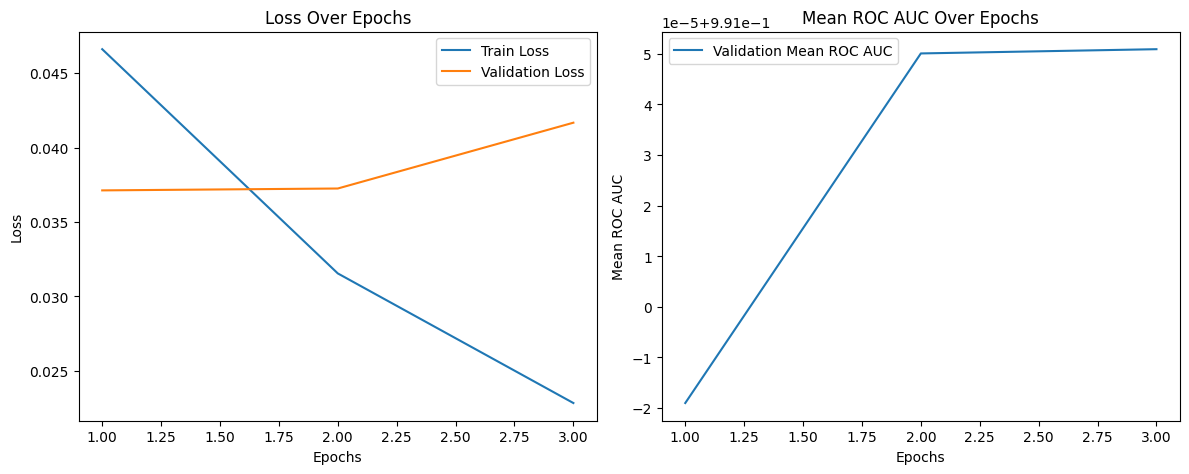

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), history['train_loss'], label='Train Loss')
plt.plot(range(1, EPOCHS + 1), history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), history['val_roc_auc'], label='Validation Mean ROC AUC')
plt.title('Mean ROC AUC Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean ROC AUC')
plt.legend()

plt.tight_layout()
plt.show()